In [2]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Callback

import pandas as pd

from transformers import BertTokenizer, BertForSequenceClassification
from huggingface_hub import PyTorchModelHubMixin

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# BERT Classifier

Our BERT classifier for the Data Chatbot.

**Relevant Resources**

- https://docs.wandb.ai/guides/integrations/lightning#logger-arguments
- https://pytorch-lightning.readthedocs.io/en/0.9.0/hyperparameters.html

## Define Dataset & DataLoader

In [3]:
class ClassifierDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.labels = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split()) # Removes any extra whitespace

        # https://huggingface.co/docs/transformers/v4.34.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.__call__
        inputs = self.tokenizer(
            text,
            None,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]', default True
            max_length=self.max_len, # Maximum length to use by one of the truncation/padding parameters
            padding='max_length', # Pad to a maximum length specified with the argument max_length
            truncation=True, # Truncate to a maximum length specified with the argument max_length
        )
        ids = inputs['input_ids'] # Indices of input sequence tokens in the vocabulary
        mask = inputs['attention_mask'] # Mask to avoid performing attention on padding token indices
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }
    

# Load data and return DataLoader
def get_dataloader(df, tokenizer, max_len=None, batch_size=32, shuffle=True, nobatch=False):
    """
    Loads data into a PyTorch DataLoader object.

    Parameters:
    - df (pd.DataFrame): The data frame containing the text and labels.
    - tokenizer (Tokenizer): The tokenizer to be used.
    - max_len (int, optional): The maximum length for the tokenized sequences. Defaults to None (model's limitation).
    - batch_size (int, optional): The size of each batch. Defaults to 32.
    - shuffle (bool, optional): Whether to shuffle the data. Defaults to True.
    - nobatch (bool, optional): Whether to disable batching. If True, batch_size will be set to the length of df. Defaults to False.

    Returns:
    - DataLoader: A PyTorch DataLoader object containing the tokenized data.

    Notes:
    - The label mapping {'harm': 0, 'question': 1, 'concern': 2} is applied to the labels in df.
    """
    label_mapping = {'harm': 0, 'question': 1, 'concern': 2}
    df['label'] = df['label'].map(label_mapping)
    dataset = ClassifierDataset(df, tokenizer, max_len)

    # Handle nobatch
    batch_size = batch_size if not nobatch else df.__len__()
    print(f"DataLoader | No Batch: {nobatch}; Batch Size: {batch_size}")

    # Create DataLoader
    params = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': 0}
    data_loader = DataLoader(dataset, **params)
    return data_loader

## Define Model

In [15]:
class BERTClassifier(pl.LightningModule, PyTorchModelHubMixin):
    def __init__(self, hparams):
        super(BERTClassifier, self).__init__()

        # Save hyperparameters
        self.hparams.update(hparams)
        self.__configure_from_hyperparams()

        self.model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
    
    def forward(self, ids, mask):
        output = self.model(ids, attention_mask=mask)
        return output.logits

    def training_step(self, batch, batch_nb):
        return self.__step(batch, batch_nb, 'train')

    def validation_step(self, batch, batch_nb):
        return self.__step(batch, batch_nb, 'val')

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-5)

    def save_pretrained(self, *args, **kwargs):
        # Forward all arguments to the inner Bert model's save_pretrained method
        self.model.save_pretrained(*args, **kwargs)

    def push_to_hub(self, *args, **kwargs):
        # Forward all arguments to the inner Bert model's push_to_hub method
        self.model.push_to_hub(*args, **kwargs)

    def __configure_from_hyperparams(self):
        # Set N/A hyperparameters to default values
        self.max_len = self.hparams.get("max_len", 100)
        self.batch_size =  self.hparams.get("batch_size", 32)

    def __step(self, batch, batch_idx, stage):
        preds, loss, accuracy, f1 = self.__get_preds_loss_accuracy(batch)
        
        self.log(
            f'{stage}/accuracy',
            accuracy,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(
            f'{stage}/f1',
            f1,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(f'{stage}/loss', loss)

        return loss

    def __get_preds_loss_accuracy(self, batch):
        # Helper function to get predictions and loss
        ids = batch['ids']
        mask = batch['mask']
        labels = batch['labels']
        
        preds = self(ids, mask)
        loss = torch.nn.CrossEntropyLoss()(preds, labels)

        # Calculate accuracy
        _, predicted = torch.max(preds, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total

        # Calculate F1 score
        labels_cpu = labels.cpu().numpy()
        predicted_cpu = predicted.cpu().numpy()
        f1 = f1_score(labels_cpu, predicted_cpu, average='macro')
        f1 = np.float32(f1)

        return preds, loss, accuracy, f1

## Helper Functions

In [5]:
class ConfusionMatrixLogger(Callback):
    def __init__(self):
        super().__init__()
        self.preds = []
        self.targets = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        ids = batch['ids']
        mask = batch['mask']
        labels = batch['labels']
        preds = pl_module(ids, mask)
        ground_truth_ids = labels.flatten().cpu().numpy()

        self.preds.extend(preds.cpu().numpy())
        self.targets.extend(ground_truth_ids)

    def on_validation_epoch_end(self, trainer, pl_module):
        all_labels = ['harm', 'question', 'concern']

        # Log the confusion matrix
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=np.argmax(np.array(self.preds), axis=1), y_true=self.targets, class_names=all_labels)
        })

        # Log the ROC curve
        probabilites = torch.nn.functional.softmax(torch.tensor(self.preds), dim=1)
        wandb.log({"roc" : wandb.plot.roc_curve(
            y_true=self.targets, y_probas=probabilites, labels=all_labels, classes_to_plot=None)
        })

        # Clear for the next epoch
        self.preds = []
        self.targets = []

In [6]:
def finetune_bert(run_config, train_dataloader, val_dataloader):
    # WandB initialization 
    wandb.login()

    # Initialize model
    model = BERTClassifier(hparams=run_config)

    # Initialize WandbLogger
    wandb_logger = WandbLogger(entity='yvokeller', project='data-chatbot') # log_model='all'
    wandb_logger.experiment.config.update(run_config)

    # Create an instance of the ConfusionMatrixLogger class
    confusion_matrix_logger = ConfusionMatrixLogger()

    # Initialize Trainer
    trainer = pl.Trainer(
        max_epochs=run_config.get('epochs'), 
        logger=wandb_logger,
        callbacks=[confusion_matrix_logger],
        log_every_n_steps=1, 
        enable_progress_bar=True,
    )

    # Train the model
    trainer.fit(model, train_dataloader, val_dataloader)

    # Close WandB logger
    wandb.finish()

    return model

## Fine-tune BERT Model

### POC with Simple Demo Dataset

In [ ]:
# WandB initialization 
wandb.login()

# Config
run_config = {
    'epochs': 5,
    'max_len': 100,
    'batch_size': 32
}

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Load training and validation data
train_df = pd.read_csv('data/train.csv')
train_dataloader = get_dataloader(train_df, tokenizer, max_len=run_config.get('max_len'), batch_size=run_config.get('batch_size'))

val_df = pd.read_csv('data/val.csv')
val_dataloader = get_dataloader(val_df, tokenizer, run_config.get('max_len'), batch_size=run_config.get('batch_size'), shuffle=False, nobatch=True)

# Finetune BERT
model = finetune_bert(run_config, train_dataloader, val_dataloader)

### Overfit on a small sample

In [ ]:
from sklearn.model_selection import train_test_split

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Config
run_config = {
    'epochs': 10,
    'max_len': None,
    'batch_size': 16
}

# Load training and validation data
train_df = pd.read_parquet('../data/train.parquet')
train_df, _ = train_test_split(train_df, train_size=64, random_state=42, stratify=train_df['label'])
train_df = train_df.reset_index(drop=True)
print('train', train_df.shape)
train_dataloader = get_dataloader(train_df, tokenizer, max_len=run_config.get('max_len'), batch_size=run_config.get('batch_size'))

val_df = pd.read_parquet('../data/test.parquet')
val_df, _ = train_test_split(val_df, train_size=64, random_state=42, stratify=val_df['label'])
val_df = val_df.reset_index(drop=True)
print('val', val_df.shape)
val_dataloader = get_dataloader(val_df, tokenizer, run_config.get('max_len'), batch_size=run_config.get('batch_size'), shuffle=False, nobatch=True)

# Fine-tune BERT
model = finetune_bert(run_config, train_dataloader, val_dataloader)

### Train on the full dataset

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Config
run_config = {
    'epochs': 6,
    'max_len': None,
    'batch_size': 32
}

# Load training and validation data
train_df = pd.read_parquet('../data/train.parquet')
train_df = train_df.reset_index(drop=True)
print('train', train_df.shape)
train_dataloader = get_dataloader(train_df, tokenizer, max_len=run_config.get('max_len'), batch_size=run_config.get('batch_size'))

val_df = pd.read_parquet('../data/test.parquet')
val_df = val_df.reset_index(drop=True)
print('val', val_df.shape)
val_dataloader = get_dataloader(val_df, tokenizer, run_config.get('max_len'), batch_size=run_config.get('batch_size'), shuffle=False, nobatch=True)

model = finetune_bert(run_config, train_dataloader, val_dataloader)

**Results**

The model achieved a validation accuracy of 97.8% after training. We are **concerned** that it **overfits on the question mark** for classifying questions, which we need to investigate further.

### Train with 50% of Question Marks removed

In [17]:
def remove_question_marks(df, frac, verbose=True):
    # Select 50% of the rows with label "question"
    question_rows = df[df['label'] == 'question'].sample(frac=0.5, random_state=42)

    # Replace question marks with empty strings
    question_rows['text'] = question_rows['text'].str.replace('?', '')

    # Update the original dataframe with the modified rows
    df.update(question_rows)

    if verbose:
        print('Total questions processed:', df['label'].value_counts())
        print('Total questions which still have a ?:',  df['text'].str.count('\?').sum())

    return df


In [18]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Config
run_config = {
    'epochs': 5,
    'max_len': None,
    'batch_size': 32
}

# Load training and validation data
train_df = pd.read_parquet('../data/train.parquet')
train_df = train_df.reset_index(drop=True)
train_df = remove_question_marks(train_df, 0.5)
print('train', train_df.shape)
train_dataloader = get_dataloader(train_df, tokenizer, max_len=run_config.get('max_len'), batch_size=run_config.get('batch_size'))

val_df = pd.read_parquet('../data/test.parquet')
val_df = val_df.reset_index(drop=True)
val_df = remove_question_marks(val_df, 0.5)
print('val', val_df.shape)
val_dataloader = get_dataloader(val_df, tokenizer, run_config.get('max_len'), batch_size=run_config.get('batch_size'), shuffle=False, nobatch=True)

model = finetune_bert(run_config, train_dataloader, val_dataloader)

Total questions processed: label
question    358
harm        358
concern     358
Name: count, dtype: int64
Total questions which still have a ?: 226
train (1074, 2)
DataLoader | No Batch: False; Batch Size: 32
Total questions processed: label
question    88
harm        88
concern     88
Name: count, dtype: int64
Total questions which still have a ?: 58
val (264, 2)
DataLoader | No Batch: True; Batch Size: 264


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 177 M 
--------------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.423   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/accuracy_epoch,▁▆███
train/accuracy_step,▁▆▇▇▇█▇▇▇▇█▇██▇██████████▇██████████████
train/f1_epoch,▁▇███
train/f1_step,▁▆▇▇▇█▇▇▇▇█▇██▇██████████▇██████████████
train/loss,█▇▆▅▄▄▃▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▁▂▃▃▃▃▃▄▁▄▄▄▄▅▅▅▁▅▅▆▆▆▆▆▁▇▇▇▇████
val/accuracy_epoch,▁▇▇█▆
val/accuracy_step,▁▇▇█▆
val/f1_epoch,▁▇▇█▆
val/f1_step,▁▇▇█▆


**Results**

Even with 50% of the question marks removed, the model showed in an experiment ran on the whole dataset, but with 50% of the question marks removed, that it is able to achieve a great validation accuracy of 98.8%. This is a good sign, as it shows that the model is not just basing its predictions on the question mark.

https://wandb.ai/yvokeller/data-chatbot/runs/81k57e2p

In [109]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from langchain.embeddings import HuggingFaceEmbeddings

train_df = pd.read_parquet('../data/train.parquet')
train_df = train_df.reset_index(drop=True)

val_df = pd.read_parquet('../data/test.parquet')
val_df = val_df.reset_index(drop=True)

# merge
df = pd.concat([train_df, val_df], ignore_index=True)
print('df', df.shape)

# remove question marks
df = remove_question_marks(df, 0.5)

unique_text = df.text.unique()
print('unique_text', unique_text.shape)

# make PLOT
def create_tsne_plot(texts, pca_dim=50, perplexity=30, learning_rate=200, eps=0.5, min_samples=2):
    # Get embeddings
    embeddings = np.array(HuggingFaceEmbeddings(model_name='bert-base-multilingual-cased').embed_documents(texts))
    print('embeddings shape', embeddings.shape)

    # Cimensionality reduction
    pca = PCA(n_components=pca_dim)
    pca_result = pca.fit_transform(embeddings)
    
    # applyt-SNE
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_iter=300, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    # apply DBSCAN to find clusters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(tsne_result)

    return pd.DataFrame({
        "Dim1": tsne_result[:, 0],
        "Dim2": tsne_result[:, 1],
        "Cluster": cluster_labels,
        "Text": texts
    })

output = create_tsne_plot(unique_text, eps=1.0)

# number of clusters
n_clusters = len(output.Cluster.unique())
print('n_clusters produced', n_clusters)

with open('cluster_output.txt', 'w') as f:
    for cluster_id, df in output.groupby("Cluster"):
        f.write(f"Cluster {cluster_id}:\n")
        for text in df.Text:
            f.write(f"{text}\n")
        f.write("\n")

df (1338, 2)
Total questions processed: label
question    446
harm        446
concern     446
Name: count, dtype: int64
Total questions which still have a ?: 284
unique_text (1328,)


No sentence-transformers model found with name /Users/yvokeller/.cache/torch/sentence_transformers/bert-base-multilingual-cased. Creating a new one with MEAN pooling.


embeddings shape (1328, 768)
n_clusters produced 28


No sentence-transformers model found with name /Users/yvokeller/.cache/torch/sentence_transformers/bert-base-multilingual-cased. Creating a new one with MEAN pooling.


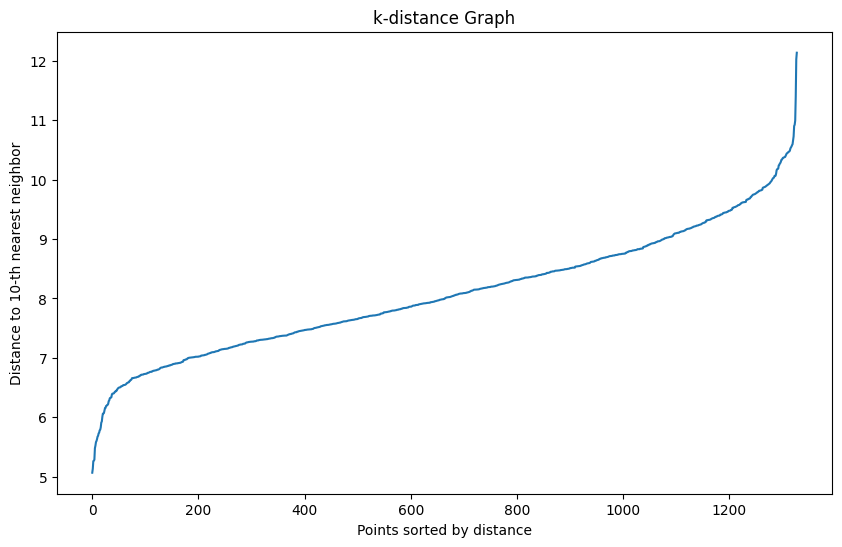

In [107]:
from sklearn.neighbors import NearestNeighbors

def create_k_distance_plot(X, k=5):
    # Assume X is your data with one sample per row
    # Choose k such that it's small compared to the number of data points, 
    # but large enough to reduce the noise in the distance calculation.
    # Common choices for k include values such as 4, 5, or 10.
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Sort the distances
    sorted_distances = np.sort(distances, axis=0)
    sorted_distances = sorted_distances[:, k-1]  # get the distance to the k-th nearest neighbor

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(sorted_distances)), sorted_distances)
    plt.title('k-distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}-th nearest neighbor')
    plt.show()

    # Look for the "elbow" in this plot to choose a good eps value


X = np.array(HuggingFaceEmbeddings(model_name='bert-base-multilingual-cased').embed_documents(unique_text))
create_k_distance_plot(X, k=2)

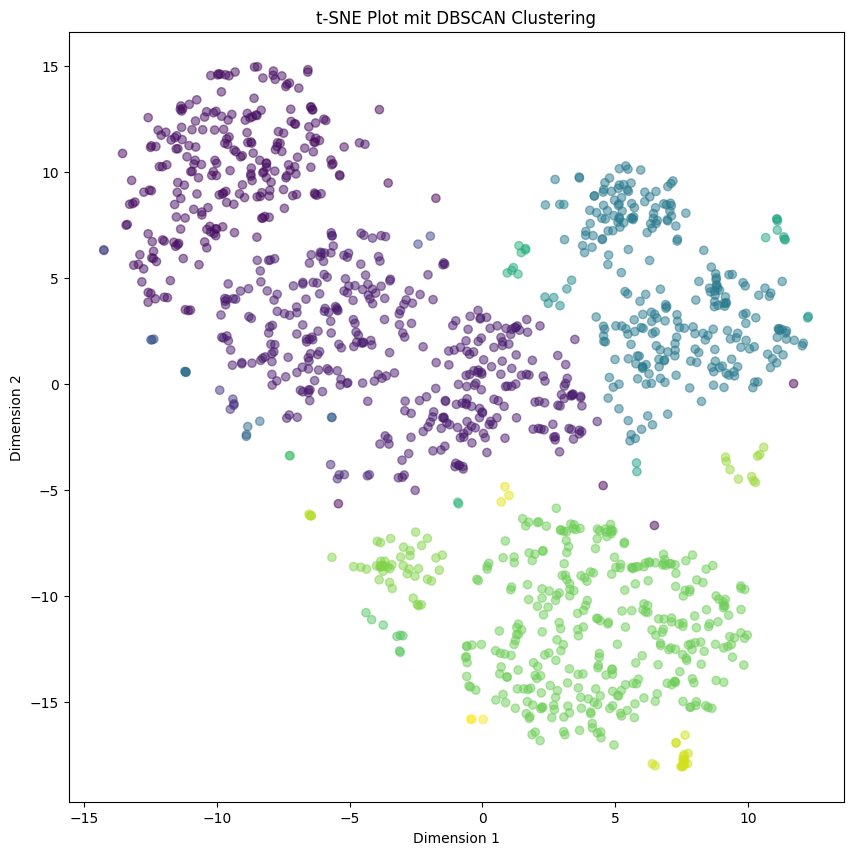

In [110]:
# plot
plt.figure(figsize=(10, 10))
plt.scatter(output.Dim1, output.Dim2, c=output.Cluster, cmap='viridis', alpha=0.5)
plt.title('t-SNE Plot mit DBSCAN Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Model Persistence

## Persist model locally

For evaluation purposes, we want to persist the model locally.

In [19]:
model.save_pretrained('bert-classifier/model')
tokenizer.save_pretrained('bert-classifier/tokenizer')

('bert-classifier/tokenizer/tokenizer_config.json',
 'bert-classifier/tokenizer/special_tokens_map.json',
 'bert-classifier/tokenizer/vocab.txt',
 'bert-classifier/tokenizer/added_tokens.json')

In [20]:
# Load model locally
loaded_model = BertForSequenceClassification.from_pretrained('bert-classifier/model', num_labels=3)
loaded_tokenizer = BertTokenizer.from_pretrained('bert-classifier/tokenizer')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Persist model on HuggingFace

Our BERT classifier for the Data Chatbot is published here: https://huggingface.co/nlpchallenges/Text-Classification/tree/main

Before pushing to the hub for the first time, make sure to run `huggingface-cli login` in your terminal, and paste the API token from your HuggingFace profile.

In [21]:
model.push_to_hub("nlpchallenges/Text-Classification")
tokenizer.push_to_hub("nlpchallenges/Text-Classification")

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nlpchallenges/Text-Classification/commit/5379bc72a25f3381fc2c2e3174f3632ef4b6408a', commit_message='Upload tokenizer', commit_description='', oid='5379bc72a25f3381fc2c2e3174f3632ef4b6408a', pr_url=None, pr_revision=None, pr_num=None)

In [21]:
loaded_tokenizer = BertTokenizer.from_pretrained('nlpchallenges/Text-Classification')
loaded_model = BertForSequenceClassification.from_pretrained('nlpchallenges/Text-Classification')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Inference

In [22]:
# Inference
def classify_text(user_input, model, tokenizer, max_len=100):
    # Tokenize the user input
    inputs = tokenizer(
        user_input,
        None,
        add_special_tokens=True, # Add '[CLS]' and '[SEP]', default True
        max_length=max_len, # Maximum length to use by one of the truncation/padding parameters
        padding='max_length', # Pad to a maximum length specified with the argument max_length
        truncation=True, # Truncate to a maximum length specified with the argument max_length
    )

    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0) # Indices of input sequence tokens in the vocabulary
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0) # Mask to avoid performing attention on padding token indices
    
    
    # Get model output
    model.eval()
    with torch.no_grad():
        output = model(ids, attention_mask=mask)
    
    # Get predicted label index
    _, predicted_idx = torch.max(output.logits, 1)
    
    # Map index to label
    label_mapping = {0: 'harm', 1: 'question', 2: 'concern'}
    return label_mapping[predicted_idx.item()]


In [56]:
classify_text("du bist sehr intelligent", loaded_model, loaded_tokenizer, max_len=None)

'concern'

In [63]:
def apply_inference(prompts):
    # create df to save results
    df = pd.DataFrame(columns=['text', 'label'])
    for user_input in qualitative_testing:
        # classify text and make data frame
        label = classify_text(user_input, loaded_model, loaded_tokenizer, max_len=None)
        entry = [user_input, label]
        df.loc[len(df)] = entry
    return df

qualitative_testing = {
    'weisst du wie das wetter heute wird?',
    'denkst du ich bin intelligent',
    'wohin muss ich morgen',
    'du bist sehr intelligent',
    'was für ein idiot',
    'ich habe angst',
    'ich bin sehr traurig',
    'ich bin sehr glücklich',
    'ich bin sehr wütend',
    'ich bin sehr aufgeregt',
    'was muss ich im modul EDA machen?',
    'Wer hat python erfunden?',
    'was macht ein affe auf dem baum?',
    'mothafucka',
    'damn du bist ein schlechter chatbot',
    'erzähl mir mal einen witz',
    'ich kann mich nicht erinnern wer das modul ALA gibt'
}

apply_inference(qualitative_testing)

,text,label
0,ich bin sehr aufgeregt,concern
1,was muss ich im modul EDA machen?,question
2,ich habe angst,harm
3,ich bin sehr glücklich,concern
4,du bist sehr intelligent,concern
5,weisst du wie das wetter heute wird?,harm
6,denkst du ich bin intelligent,harm
7,wohin muss ich morgen,harm
8,damn du bist ein schlechter chatbot,harm
9,was für ein idiot,harm


**Qualitative Testing Results**

- Seems to not work for passive questions
- Identifies too much harm